In [30]:
%load_ext autoreload
%autoreload 2
from rekall import Interval, IntervalSet, IntervalSetMapping, Bounds3D
from rekall.predicates import *
from vgrid import VGridSpec, VideoMetadata, VideoBlockFormat, FlatFormat
from vgrid_jupyter import VGridWidget
import urllib3, requests, os
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Hack to disable warnings about olimar's certificate
urllib3.disable_warnings()

VIDEO_COLLECTION_BASEURL = "https://olimar.stanford.edu/hdd/parking_lot/"
VIDEO_METADATA_FILENAME = 'parking_lot_videos.json'

# Load video file metadata
video_metadata = [ VideoMetadata(v['filename'], id=v['id'], fps=v['fps'],
                                 num_frames=v['num_frames'], width=v['width'],
                                 height=v['height'])
                  for v in requests.get(os.path.join(
                      VIDEO_COLLECTION_BASEURL, VIDEO_METADATA_FILENAME),
                                        verify=False).json() ]

VIDEO_FOLDER = 'videos'
BBOX_FOLDER = 'bboxes'

In [9]:
# limit to a subset of videos
min_video = '20190702_092328_no_sound.mp4'
max_video = '20190702_193116_no_sound.mp4'

video_metadata = [
    vm
    for vm in video_metadata if vm.path >= min_video and vm.path <= max_video
]

len(video_metadata)

14

In [10]:
parking_spot_video = '20190702_153730_no_sound.mp4'
parking_spot_metadata = [
    vm
    for vm in video_metadata if vm.path == parking_spot_video
][0]
parking_spot_metadata.id

1

In [11]:
bboxes = [
    pickle.loads(requests.get(
        os.path.join(
            os.path.join(VIDEO_COLLECTION_BASEURL, BBOX_FOLDER),
            os.path.join(vm.path[:-4], 'bboxes.pkl')
        ),
        verify=False
    ).content)
    for vm in video_metadata
]
bboxes_ism = IntervalSetMapping({
    metadata.id: IntervalSet([
        Interval(
            Bounds3D(
                t1 = 30 * i / metadata.fps,
                t2 = 30 * (i + 1) / metadata.fps,
                x1 = bbox[0] / metadata.width,
                x2 = bbox[2] / metadata.width,
                y1 = bbox[1] / metadata.height,
                y2 = bbox[3] / metadata.height
            ),
            payload = { 'class': bbox[4], 'score': bbox[5] }
        )
        for i, frame in enumerate(bbox_frame_list)
        for bbox in frame
    ])
    for bbox_frame_list, metadata in tqdm(zip(bboxes, video_metadata), total = len(bboxes))
})

100%|██████████| 14/14 [00:05<00:00,  2.87it/s]


In [19]:
vgrid_spec = VGridSpec(
    video_meta = video_metadata,
    vis_format = VideoBlockFormat(imaps = [
        ('bounding_boxes', IntervalSetMapping({
            1: bboxes_ism.get_grouped_intervals()[1].filter(
                lambda intrvl: intrvl['payload']['class'] == 'car'
            )
        }))
    ]),
    video_endpoint = os.path.join(VIDEO_COLLECTION_BASEURL, VIDEO_FOLDER)
)
VGridWidget(vgrid_spec = vgrid_spec.to_json_compressed())

VGridWidget(vgrid_spec={'compressed': True, 'data': b'x\x9c\xc4\xbd\xcd\x8e%\xdb\x92\x9c\xf7*D\x8f\x05a\xfd\xf…

In [25]:
parking_spots_set = bboxes_ism.get_grouped_intervals()[1].filter(
    lambda intrvl: intrvl['t1'] == 0.0 and intrvl['payload']['class'] == 'car'
)

In [27]:
parking_spots = sorted([
    {
        'x1': intrvl['x1'],
        'x2': intrvl['x2'],
        'y1': intrvl['y1'],
        'y2': intrvl['y2']
    }
    for intrvl in parking_spots_set.get_intervals()
], key = lambda item: item['x1'])

In [28]:
parking_spots

[{'x1': 0.0,
  'x2': 0.08424050211906434,
  'y1': 0.5207680172390408,
  'y2': 0.6528446621365017},
 {'x1': 0.0770739495754242,
  'x2': 0.16108734607696534,
  'y1': 0.5190534379747179,
  'y2': 0.6503598531087239},
 {'x1': 0.16353940963745117,
  'x2': 0.2407153844833374,
  'y1': 0.5117196400960287,
  'y2': 0.636061520046658},
 {'x1': 0.25799615383148194,
  'x2': 0.31947376728057864,
  'y1': 0.5125064849853516,
  'y2': 0.6232725355360244},
 {'x1': 0.340884804725647,
  'x2': 0.40604052543640134,
  'y1': 0.4878042432996962,
  'y2': 0.6180920071072049},
 {'x1': 0.41316685676574705,
  'x2': 0.4804346561431885,
  'y1': 0.4915266672770182,
  'y2': 0.6030947791205512},
 {'x1': 0.4957833766937256,
  'x2': 0.5689880847930908,
  'y1': 0.494759284125434,
  'y2': 0.622841559516059},
 {'x1': 0.5707062244415283,
  'x2': 0.6506856441497803,
  'y1': 0.49639108445909286,
  'y2': 0.6022100236680773},
 {'x1': 0.645266056060791,
  'x2': 0.7266099452972412,
  'y1': 0.4873125712076823,
  'y2': 0.60356873406304

# Visualize individual frames

In [38]:
def visualize(video, imagename):
    FOLDER_PATH = '/home/danfu/rekall_experiments/parking_space_experiments/images_ffmpeg'
    if video[-3:] == 'mp4':
        video = video[:-4]
    image_folder = os.path.join(FOLDER_PATH, video)
    
    img = Image.open(os.path.join(image_folder, imagename))
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

In [32]:
videos = sorted([
    (vm.path, vm.id)
    for vm in video_metadata
])
videos

[('20190702_092328_no_sound.mp4', 21),
 ('20190702_101014_no_sound.mp4', 5),
 ('20190702_105659_no_sound.mp4', 11),
 ('20190702_114344_no_sound.mp4', 13),
 ('20190702_123029_no_sound.mp4', 23),
 ('20190702_131714_no_sound.mp4', 25),
 ('20190702_140400_no_sound.mp4', 7),
 ('20190702_145045_no_sound.mp4', 19),
 ('20190702_153730_no_sound.mp4', 1),
 ('20190702_162415_no_sound.mp4', 0),
 ('20190702_171100_no_sound.mp4', 17),
 ('20190702_175745_no_sound.mp4', 22),
 ('20190702_184430_no_sound.mp4', 16),
 ('20190702_193116_no_sound.mp4', 26)]

In [316]:
cur_video = videos[13]
cur_video

('20190702_193116_no_sound.mp4', 26)

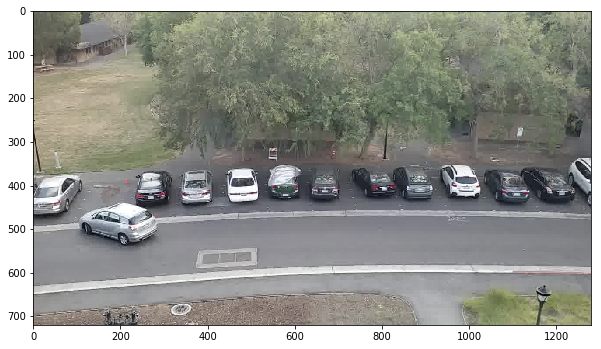

In [334]:
visualize(cur_video[0], '1752.jpg')

In [335]:
empty_parking_spaces = [
    # (video ID, parking space number (index into parking_spots), start_img, end_img)
    (21, 4, '0001.jpg', '1210.jpg'),
    (21, 6, '0001.jpg', '0154.jpg'),
    (21, 2, '2062.jpg', '2803.jpg'),
    (5, 2, '0001.jpg', '2804.jpg'),
    (11, 2, '0001.jpg', '0266.jpg'),
    (13, 11, '0437.jpg', '2804.jpg'),
    (13, 9, '2067.jpg', '2804.jpg'),
    (13, 2, '2666.jpg', '2804.jpg'),
    (23, 11, '0001.jpg', '2804.jpg'),
    (23, 9, '0001.jpg', '2804.jpg'),
    (23, 2, '0001.jpg', '1985.jpg'),
    (23, 2, '2389.jpg', '2804.jpg'),
    (23, 8, '2417.jpg', '2804.jpg'),
    (25, 11, '0001.jpg', '2804.jpg'),
    (25, 9, '0001.jpg', '2024.jpg'),
    (25, 2, '0001.jpg', '2804.jpg'),
    (25, 8, '0001.jpg', '2804.jpg'),
    (7, 11, '0001.jpg', '2352.jpg'),
    (7, 2, '0001.jpg', '1174.jpg'),
    (7, 8, '0001.jpg', '2803.jpg'),
    (7, 9, '0337.jpg', '0700.jpg'),
    (19, 8, '0001.jpg', '0139.jpg'),
    # no empty parking spaces in video 1
    (0, 6, '2585.jpg', '2803.jpg'),
    (17, 6, '0001.jpg', '0217.jpg'),
    (17, 6, '0457.jpg', '2296.jpg'),
    (17, 4, '0996.jpg', '2585.jpg'),
    (17, 8, '1909.jpg', '2654.jpg'),
    (22, 10, '0313.jpg', '1722.jpg'),
    (22, 8, '0650.jpg', '1066.jpg'),
    (16, 2, '0940.jpg', '1514.jpg'),
    (26, 1, '1687.jpg', '1751.jpg')
]

# Visualize Empty Parking Space Annotations

In [346]:
empty_parking_space_intervals = {}
for empty_spaces in empty_parking_spaces:
    video_id = empty_spaces[0]
    if video_id not in empty_parking_space_intervals:
        empty_parking_space_intervals[video_id] = []
    box = parking_spots[empty_spaces[1]]
    start_img = int(empty_spaces[2][:-4])
    end_img = int(empty_spaces[3][:-4])
    
    vm = [
        vm
        for vm in video_metadata if vm.id == video_id
    ][0]
    
    # Create intervals
    empty_parking_space_intervals[video_id] += [
        Interval(
            Bounds3D(
                t1 = (i - 1) * 30 / vm.fps,
                t2 = i * 30 / vm.fps,
                x1 = box['x1'],
                x2 = box['x2'],
                y1 = box['y1'],
                y2 = box['y2']
            )
        )
        for i in range(start_img, end_img + 1)
    ]

In [367]:
empty_parking_space_ism = IntervalSetMapping({
    video_id: IntervalSet(empty_parking_space_intervals[video_id])
    for video_id in empty_parking_space_intervals
})

In [368]:
vgrid_spec = VGridSpec(
    video_meta = video_metadata,
    vis_format = VideoBlockFormat(imaps = [
        ('empty_spaces', empty_parking_space_ism)
    ]),
    video_endpoint = os.path.join(VIDEO_COLLECTION_BASEURL, VIDEO_FOLDER)
)
VGridWidget(vgrid_spec = vgrid_spec.to_json())

VGridWidget(vgrid_spec={'interval_blocks': [{'interval_sets': [{'name': 'empty_spaces', 'interval_set': [{'bou…

# Save Annotations

In [374]:
root_path = '/home/danfu/rekall_experiments/parking_space_experiments/'
annotations_path = '/home/danfu/rekall_experiments/parking_space_experiments/empty_spaces'
image_path = '/home/danfu/rekall_experiments/parking_space_experiments/images_ffmpeg'
for video, video_id in tqdm(videos):
    folder_name = video[:-4]
    folder_path = os.path.join(annotations_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    vm = [
        vm
        for vm in video_metadata if vm.id == video_id
    ][0]
    
    output = []
    
    num_images = len(os.listdir(os.path.join(image_path, folder_name)))
    for frame in range(num_images):
        frame_output = []
        image_name = '{:04d}.jpg'.format(frame + 1)
        for eps in empty_parking_spaces:
            if (eps[0] == video_id and
                image_name >= eps[2] and
                image_name <= eps[3]):
                box = parking_spots[eps[1]]
                frame_output.append([
                    box['x1'] * vm.width, 
                    box['y1'] * vm.height, 
                    box['x2'] * vm.width, 
                    box['y2'] * vm.height, 
                    image_name
                ])
        output.append(frame_output)
    
    with open(os.path.join(folder_path, 'gt.pkl'), 'wb') as f:
        pickle.dump(output, f)

100%|██████████| 14/14 [00:00<00:00, 119.78it/s]


# Dev/Test Split

In [375]:
dev_set = [
    21, 11, 23, 7, 1, 17, 16
]
test_set = [
    5, 13, 25, 19, 0, 22, 26
]

In [378]:
# Save dev/test split
with open('/home/danfu/rekall_experiments/parking_space_experiments/dev.txt', 'w') as f:
    for video_id in dev_set:
        vm = [
            vm
            for vm in video_metadata if vm.id == video_id
        ][0]
        f.write('{}\n'.format(vm.path))
with open('/home/danfu/rekall_experiments/parking_space_experiments/test.txt', 'w') as f:
    for video_id in test_set:
        vm = [
            vm
            for vm in video_metadata if vm.id == video_id
        ][0]
        f.write('{}\n'.format(vm.path))